In [3]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import numpy as np
import math
import IPython.html.widgets as widgets
from IPython.html.widgets import interactive
from IPython.display import display

/usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<h1 style="text-decoration: underline, overline; color: navy;">Rapport de stage</h1>

<h2 style="text-decoration: underline;">Robot controlé par DNF</h2>

Le but de ce stage consiste à utiliser des champs neuronaux dynamiques (ou DNF : Dynamic Neural Fields), c'est à dire plusieurs éléments permettant un calcul décentralisé et distribué avec un comportement émergent face à un stimulis extérieur, pour permettre l'élaboration d'un robot autonome capable d'éviter des obstacles.

Pour cette première expérience le modèle de robot utilisé sera un e-puck : un petit robot cylindrique avec des capteurs infrarouges tout autour de lui et une caméra. Les stimulis extérieurs seront donc pour cette première partie les capteurs de proximité infrarouge.

###I. Théorie et calculs

####1) DNF infrarouges

Les champs neuronaux dynamiques sont directement reliés aux capteurs infrarouges puis pour savoir quel angle semble le plus suceptible d'être un obstacle, on va utiliser l'activation du DNF qui va renvoyer 0 si rien n'est détecté ou une valeur positive sinon.

Sur le schéma suivant, l'intensité du capteur a été multiplié par 100. L'intensité du capteur est égal à la distance maximale de réception moins la distance actuele détectée. Elle varie donc de 0 à 0.04 m.

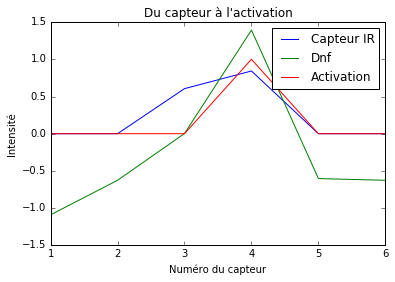

In [5]:
x = np.array([1, 2, 3, 4, 5, 6])
ir = np.array([0.000000000000000000e+00,
0.000000000000000000e+00,
6.056077528688350031e-03,
8.428876313973869550e-03,
0.000000000000000000e+00,
0.000000000000000000e+00])
ir=ir*100
dnf = np.array([-1.090321063995361328e+00,
-6.263688206672668457e-01,
2.505307266418066447e-03,
1.392887643318315938e+00,
-6.031024456024169922e-01,
-6.263688206672668457e-01])
activation = np.array([0,0,0,1,0,0])

plt.plot(x,ir,label='Capteur IR')
plt.plot(x,dnf,label='Dnf')
plt.plot(x,activation,label='Activation')
plt.legend()
plt.xlabel("Numéro du capteur")
plt.ylabel("Intensité")
plt.title("Du capteur à l'activation")
plt.show()

Sur le schéma ci-dessus, le nombre de capteurs est de 6 (les capteurs situés devant le robot E-Puck), pour avoir une plus grande utilité des DNF, nous avons modifié le robot virtuel pour avoir 50 capteurs. En réalité seulement la moitié est utilisée, ce qui permet ainsi au robot de revenir vers la cible dès qu'il n'a plus la cible devant.

#### 2) DNF direction

Nous avons ensuite rajouté une cible dont le robot ne connait que la direction de la même manière que pour les DNF des capteurs infrarouges.

#### 3) Navigation

Dans le but d'avoir un comportement intéressant face aux obstacles, nous avons décidé que la navigation serait régit par deux activations, l'une correspondant à la présence d'obstacle et l'autre la direction de la cible inhibé par la présence d'obstacle dans cette même direction.

Ainsi le robot va toujours en direction de la cible excepté dans le cas de la présence d'un obstacle entre eux deux, dans ce cas le robot tournera autour de l'obstacle jusqu'à retrouver la direction de la cible.

Nous avions aussi envisagé un déplacement de l'activation de la direction dans le cas d'un obstacle devant, mais cette manipulation demandant avec le logiciel DNFPY un mouvement très lent n'était pas envisageable dans ce cadre là bien que ce soit plus proche d'un comportement naturel.

#### 5) Vitesse des roues

La formule permettant de calculer la vitesse se base sur les activations ci-dessus.
$v=\frac{\sum_{x=-\Pi}^{+\Pi}(Fd(x)*activationN(x))+\sum_{x=-\Pi}^{+\Pi}(Fo(x)*activationI(x))}{\sum_{x=-\Pi}^{+\Pi}activationI(x)+\sum_{x=-\Pi}^{+\Pi}activationN(x)}$

Avec $Fd = \frac{2}{1+e^{(\pm x)}}-0.5$ et $Fo = \frac{2}{1+e^{(\pm x*10)}}-1$.

Les fonction étant inverse selon le moteur correspondant de telle manière que le robot s'écarte des obstacles et se rapproche de la cible.

##### a) Face à un obstacle

Dans le cas d'un seul obstacle situé entre la cible et le robot, l'activation N étant inhibé, on peut simplifier la formule de cet manière :

$v=\frac{\sum_{x=-\Pi}^{+\Pi}(Fo(x)*activationI(x))}{\sum_{x=-\Pi}^{+\Pi}activationI(x)}$

L'activation est une gaussienne mais prenons ici une activation de type porte avec un obstacle ponctuel pour simplifier. On peut donc prendre $v=Fo(x)= \frac{2}{1+e^{(\pm x*10)}}-1$

Voici les vitesses des roues :



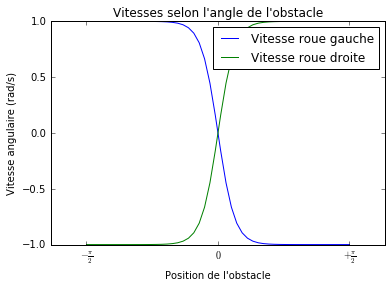

In [6]:
x, st = np.linspace(-math.pi/2,math.pi/2, retstep=True)
vL = 2/(1+np.exp(x*10))-1
vR = 2/(1+np.exp(-x*10))-1
plt.plot(x,vL,label='Vitesse roue gauche')
plt.plot(x,vR,label='Vitesse roue droite')
plt.legend()
plt.xlabel("Position de l'obstacle")
plt.ylabel("Vitesse angulaire (rad/s)")
plt.title("Vitesses selon l'angle de l'obstacle")
plt.xticks([-math.pi/2, 0, math.pi/2], [r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$'])
plt.show()


Pour vérifier le bon fonctionnement dynamique de la formule face à un obstacle, observons $\frac{d\psi}{dt} = \omega$ en fonction de $\psi$, l'angle du robot dans le repère absolu.

Nous connaissons la taille de l'axe des deux roues ($\Delta = 52 mm$) et le rayon des roues ($r = 20.5 mm$).
On en déduit que face à un obstacle $\omega =\frac{r}{\Delta}(v_d-v_g)= \frac{2r}{\Delta}v_d$ avec $v_d = -v_g$ la vitesse angulaire du moteur droit.

Et hors de l'obstacle $\omega = 0rad/s$ car les deux roues vont à la même vitesse.

On a donc 
$$\omega = \frac{d\psi}{dt} =   
\left \{
   \begin{array}{r, c, l}
      \frac{4r}{\Delta (1+e^{(-\psi+\phi)*10} -1)} & si & x \in [-\frac{\pi}{2},\frac{\pi}{2}] \\
      0 & sinon &
   \end{array}
\right .
$$

Sur le graphe ci-dessous qui reprèsente $\omega$, le point rouge correspond à un point fixe instable ou répulseur. En effet, à droite du point la dérivée est positive donc l'angle va augmenter et à gauche elle est négative donc l'angle va diminuer.

In [7]:
def plotPsi(phi):
    x=np.linspace(-math.pi,math.pi)
    vR = 2/(1+np.exp((-x+phi)*10))-1
    for i in range(50):
        if x[i]<-math.pi/2+phi or x[i]>math.pi/2+phi:
            vR[i]=0
    r=20.5
    delta=52
    w=2*r/delta*vR
    plt.plot(x,w, label='Rotation')
    plt.scatter(phi,w[phi], 40, color ='red')
    plt.legend()
    plt.xlabel("Angle psi")
    plt.ylabel("Rotation du robot (rad/s)")
    plt.title("Dynamique selon l'obstacle situé à "+str(phi)+" rad")
    plt.xticks([-math.pi,-math.pi/2, 0, math.pi/2, math.pi],[r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$'])
    plt.show()

slider_phi = widgets.FloatSliderWidget(min=-math.pi/2, max=math.pi/2, step=0.1, value=0)
w=widgets.interactive(plotPsi,phi = slider_phi)
display(w)

AttributeError: FloatSliderWidget

#####b) Cas de l'obstacle double

Un des buts de cet méthode de calcul de la vitesse et de pouvoir gérer deux obstacles situés devant le robot avec parfois la possibilité de passer entre. Les DNFs permettent d'avoir une activation qui se regroupe ou deux activations séparés selon l'angle de l'obstacle.

Pour étudier la réaction du robot face à de tels obstacles, nous avons fait une expérience sur V-Rep à l'aide d'un scénario. On positionne deux cubes devant le robot avec l'interstice entre les deux qui augmentent à chaque fois, on récupère à t donné la vitesse de rotation du robot. La vitesse de rotation est aléatoirement positive ou négative mais pour une plus belle visualisation, nous avons représenté la valeur absolue et son négatif.

Le robot tournera soit à droite, soit à gauche face à l'obstacle si la distance est courte. Si il a la place de passer (avec une certaine marge de confiance), il continuera tout droit.

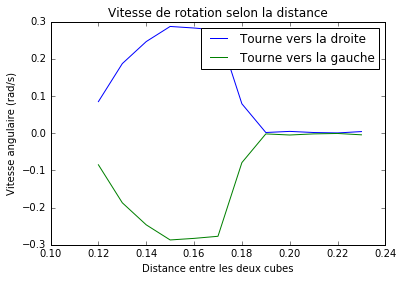

In [8]:
dist=np.array([0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115])
dist=dist*2
dpdt=[0.08491489,0.18710179,-0.24631846,-0.28696026,0.28273605,0.27711486,-0.07904169,0.00187831,0.00484938,-0.00184582,0.00069609,0.00435697]
dpdta=np.abs(dpdt)
dpdtb=-dpdta
plt.plot(dist,dpdta,label='Tourne vers la droite')
plt.plot(dist,dpdtb,label='Tourne vers la gauche')
plt.legend()
plt.xlabel("Distance entre les deux cubes")
plt.ylabel("Vitesse angulaire (rad/s)")
plt.title("Vitesse de rotation selon la distance")

plt.show()

#####c) Sans obstacle

Rappel de la formule de la vitesse des moteurs dans ce cas :

$v=\frac{\sum_{x=-\Pi}^{+\Pi}(Fd(x)*activationN(x))}{\sum_{x=-\Pi}^{+\Pi}activationN(x)}$

On peut de la même manière que dans le cas d'un obstacle prendre $v = Fd(x) = \frac{2}{1+e^{(\pm x)}}-0.5$. 


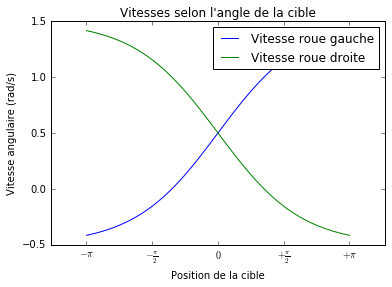

In [9]:
x, st = np.linspace(-math.pi,math.pi, retstep=True)
vL = 2/(1+np.exp(-x))-0.5
vR = 2/(1+np.exp(x))-0.5
plt.plot(x,vL,label='Vitesse roue gauche')
plt.plot(x,vR,label='Vitesse roue droite')
plt.legend()
plt.xlabel("Position de la cible")
plt.ylabel("Vitesse angulaire (rad/s)")
plt.title("Vitesses selon l'angle de la cible")
plt.xticks([-math.pi,-math.pi/2, 0, math.pi/2,math.pi], [r'$-\pi$',r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$',r'$+\pi$'])
plt.show()

La réunion de ces deux courbes correspond à un point fixe stable ou attracteur que l'on pourrait retrouver en traçant la vitesse de rotation de la même façon que dans le cas d'un obstacle ponctuel.


###II. Programmation

Pour arriver à ce résulat deux outils ont été utilisés :
* Vrep : simulateur de robot
* DNFPY : le logiciel codant des DNF en python par Benoit


DNFPY utilise un système de map reliée entre elle par parenté. Les racines correspondent au résultat qui fait appel à une classe fille pour les calculs et ainsi de suite.

####1) Hiérarchie des cartes

L'organisation des maps est créé dans la classe ModelEPuckDNF comme suit :

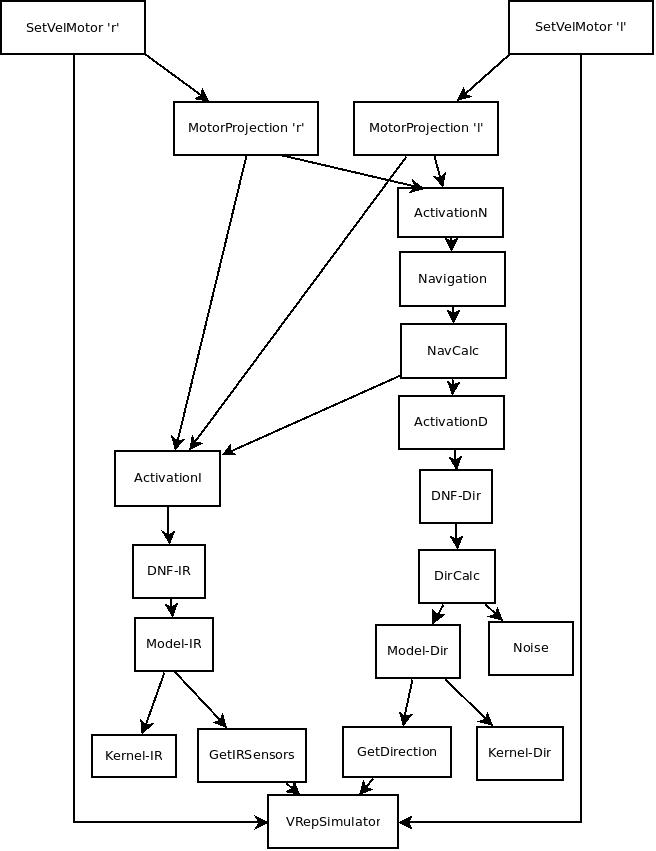

In [10]:
Image(filename='Organigramme.jpeg') 

####2) La classe VRepSimulator

Cette classe a pour but de servir d'interface entre DNFPY et vrep.

Elle permet d'initialiser une map simulator donc les diverses fonctions sont :
* connection : permet la connexion avec Vrep et le lancement de la simulation
* disconnection : met fin à la connexion et à la simulation
* startSimulation : lance la simulation
* stopSimulation :stop la simulation
* initHandle : initialise les poignées dans le dictionnaire si besoin
* compute : fait un pas d'itération dans le cas du mode synchrone
* getSensor : récupère les données d'un capteur
* getSensors : récupère les données de plusieurs capteurs
* setController : permet de modifier l'ordre d'un controleur
* getOrientation : donne l'orientation d'un objet (angle d'Euler) dans le repère absolu ou d'un autre objet
* getPosition : donne la position d'un objet (repère absolu ou relatif)
* setPositionObject : change la position d'un objet (repère absolu ou relatif)
* copyObject : copie un objet et le colle à la position indiquée (repère absolu ou relatif)

Les fonctions pythons pour vrep utilisés sont en annexe.

####3) La classe GetIRSensors

Elle a comme enfant la map VRepSimulator et en récupère les données des capteurs de proximité infrarouge ePuck dans une liste.

####4) La classe GetDirection

Elle a comme enfant la map VRepSimulator et en récupère l'angle entre le devant du robot et la cible.


####5) La classe MotorProjection

Elle a comme enfant les maps VRepSimulator et les deux activations. Le gros du travail est effectué ici. C'est cette classe qui s'occupe de faire la moyenne pondérée et de la transformer en vitesse grâce à la formule vu dans la première partie.

####6) La classe SetVelMotor

C'est la racine double (pour chaque roue) des maps. Elle a comme enfant la map MotorProjection. Elle s'occupe de transmettre la valeur de la vitesse au moteur.

####7) Autres classes de DNFPY

Les autres maps sont propres aux DNF, elles permettent notamment de rajouter du bruit et de permettre des opérations entre les différentes activations de DNF.

###Conclusion

Le programme tel qu'il est permet de répondre au but demandé même si le choix d'un robot avec 50 capteurs risque d'être irréalisable dans un cas réel.
De nombreuses possibilités d'améliorations seraient imaginables tel une plus grande prise en compte de cas particuliers, ce qui pourrait se traduire par l'insertion d'une mémoire des obstacles préalablements rencontrés permettant ainsi de se sortir de situations avec de nombreux obstacles formant plus ou moins un labyrinthe. Ou encore l'utilisation de la caméra pour déceler la cible plutôt que des commandes du simulateur pour se rapprocher d'un cas réel.

D'un point de vue personnel, ce stage m'a permit de développer mes compétences en programmation, particulièrement le Python dont je n'avais que peu de connaissances. Mais aussi d'avoir une meilleure compréhension du fonctionnement des champs neuronaux dynamiques et de la recherche en informatique en général. Ces deux sujets pouvant m'être utile dans le cadre de mes projets futurs. 

### Annexe

#### Commande Python utilisé dans la classe VRepSimulator

Voici les diverses commandes associées à Vrep que l'on retrouve dans les fonctions précédentes :

* Connexion et déconnexion :

clientID=vrep.simxStart('127.0.0.1',port,True,True,5000,5)
vrep.simxFinish(clientID)

* Mode synchrone :

vrep.simxSynchronous(clientID,True) #active le mode synchrone

vrep.simxSynchronousTrigger(clientID) #permet de rajouter un pas

* Simulation :

vrep.simxStartSimulation(clientID,vrep.simx_opmode_oneshot_wait)

vrep.simxStopSimulation(clientID,vrep.simx_opmode_oneshot_wait)

* Permet d'obtenir un handle :
    
errorCode,sensor_handle=vrep.simxGetObjectHandle(clientID,'ePuck_proxSensor1',vrep.simx_opmode_oneshot_wait)


* Appel d'un capteur de proximité :

errorCode,detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(clientID,sensor_handle,vrep.simx_opmode_streaming)


* Changer la valeur des moteurs :

errorCode=vrep.simxSetJointTargetVelocity(clientID,left_motor_handle,vl, vrep.simx_opmode_streaming)

* Obtenir orientation et position :

returnCode,angles=vrep.simxGetObjectOrientation(clientID,objectHandle,relativeHandle,vrep.simx_opmode_streaming)

returnCode,arrayPosition=vrep.simxGetObjectPosition(clientID,objectHandle,relativeHandle,vrep.simx_opmode_streaming)

* Copier des objets :

returnCode, newObjectHandles=vrep.simxCopyPasteObjects(clientID, objectHandles, vrep.simx_opmode_oneshot_wait) #newObjectHandles et objectHandles sont des listes

####Commandes Lua utilisé pour augmenter le nombre de capteur :

* Copie d'objet existant

copiedObjectHandles=simCopyPasteObjects(objectHandles, options)

* Récupération des coordonnées

position=simGetObjectPosition(objectHandle, relativeToObjectHandle)

eulerAngles=simGetObjectOrientation(objectHandle, relativeToObjectHandle)

* Nouvelles coordonnées

result=simSetObjectOrientation(objectHandle, relativeToObjectHandle, eulerAngles)

result=simSetObjectPosition(objectHandle, relativeToObjectHandle, position)
